In [1]:
import tensorflow as tf
import numpy as np
import random

#tf.compat.v1.enable_eager_execution()
# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

C:\Users\Sara Limeta\AppData\Local\Temp\ipykernel_41168\284860553.py:16: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Found 985 files belonging to 3 classes.
Using 788 files for training.
Found 985 files belonging to 3 classes.
Using 197 files for validation.


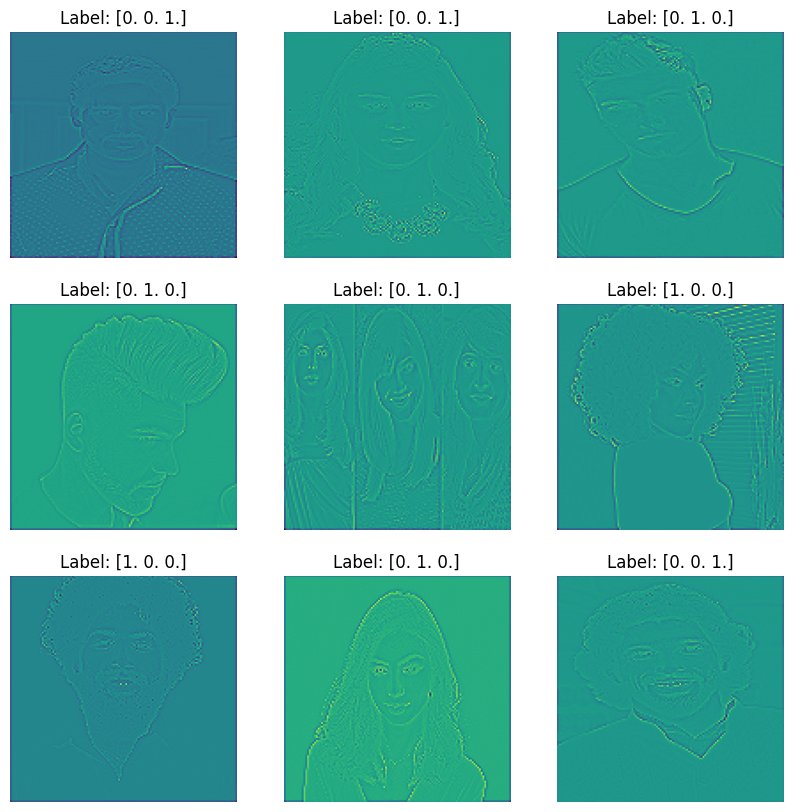

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

image_size = (128, 128)
batch_size = 32
    
def laplacian_sharpening(image):
    # Convert the image to grayscale
    gray_image = tf.image.rgb_to_grayscale(image)
    
    # Normalize the pixel values to [0, 1]
    #normalized_image = gray_image / 255.0
    
    # Define the Laplacian kernel
    laplacian_kernel = tf.constant([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=tf.float32)
    laplacian_kernel = tf.reshape(laplacian_kernel, [3, 3, 1, 1])  # Reshape to match convolution requirements
    
    # Apply Laplacian sharpening using convolution
    laplacian_image = tf.nn.conv2d(gray_image, laplacian_kernel, strides=[1, 1, 1, 1], padding='SAME')
    
    # Scale the Laplacian image to match the original image
    scaled_laplacian_image = laplacian_image * 25.0  # Adjust the scaling factor as needed
    
    # Add the scaled Laplacian image to the original image
    sharpened_image = gray_image + scaled_laplacian_image
    
    return sharpened_image

'''def histogram_equalization(image):
    # Flatten the image
    flattened_image = tf.reshape(image, [-1])

    print("Flattened shape:", flattened_image.shape)
    
    # Compute the histogram of the flattened image
    hist = tf.histogram_fixed_width(flattened_image, [0.0, 255.0], nbins=256)

    # Compute the cumulative distribution function (CDF) of the histogram
    cdf = tf.cumsum(hist)

    # Normalize the CDF
    cdf_normalized = cdf / tf.reduce_max(cdf)

    # Map the pixel values to their corresponding equalized values using the CDF
    equalized_image = tf.gather(cdf_normalized * 255, tf.cast(flattened_image, tf.int32))

    # Reshape the equalized image to its original shape
    equalized_image = tf.reshape(equalized_image, tf.shape(image))

    return equalized_image'''

    
def preprocess_image(image, label):
   
    sharpened_image = laplacian_sharpening(image)

    normalized_image = sharpened_image / 255.0
    return normalized_image, label


# Load the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
).map(preprocess_image)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
).map(preprocess_image)

# Display a few preprocessed images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        #plt.imshow(images[i])  # Normalize pixel values to [0, 1]
        plt.imshow(images[i] / 255.0)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
plt.show()




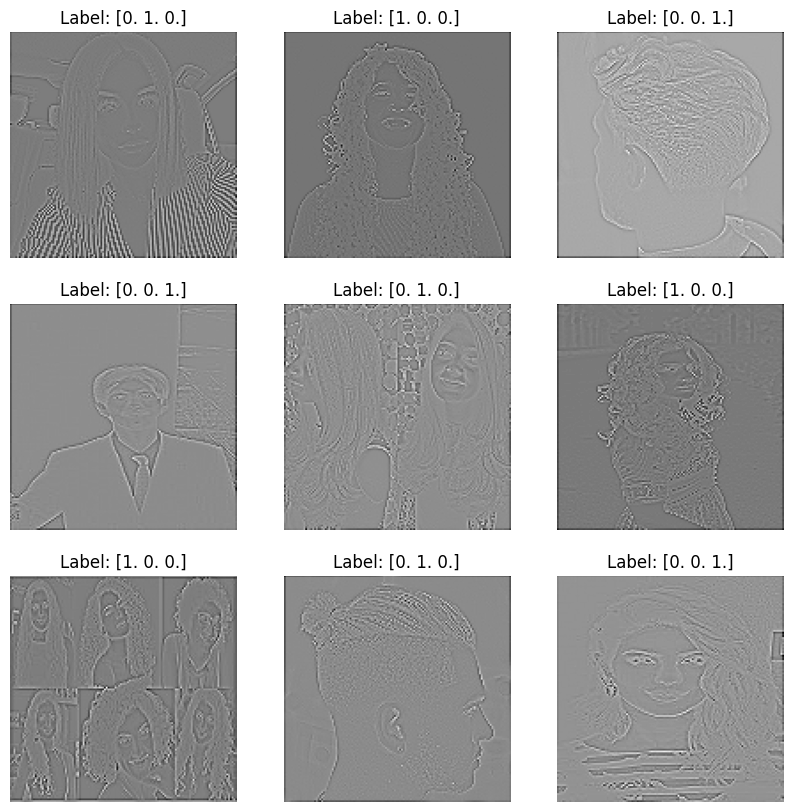

In [3]:

# Display a few preprocessed images from the training dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i] / 255.0, cmap='gray')
 # Normalize pixel values to [0, 1]
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
plt.show()

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
import time

#cropping_size = (52, 52)
#rotation_range = 0.6

model = Sequential()
model.add(keras.Input(shape=image_size + (1,))) # 64, 64, 3
#model.add(layers.Rescaling(1.0 / 255))
model.add(layers.Conv2D(filters=4, kernel_size=(16,16), strides=1, padding='valid', dilation_rate=1))
#model.add(layers.BatchNormalization()) 
model.add(layers.Activation("swish"))
#model.add(layers.Dropout(0.25))  

model.add(layers.Conv2D(filters=8, kernel_size=(8,8), strides=1, padding='valid', dilation_rate=1))
#model.add(layers.BatchNormalization()) 
model.add(layers.Activation("swish"))
#model.add(layers.Dropout(0.25)) 

model.add(layers.Conv2D(filters=16, kernel_size=(4,4), strides=1, padding='valid', dilation_rate=1))
#model.add(layers.BatchNormalization()) 
model.add(layers.Activation("swish"))
#model.add(layers.Dropout(0.25)) 

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(64, activation='swish'))
model.add(layers.Dense(3, activation='softmax'))

from tensorflow.keras.callbacks import EarlyStopping

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile your model again
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

epochs = 50

start_time = time.time()
# Train your model with the EarlyStopping callback
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[callback])
#history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
end_time = time.time()

training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, AUC, CategoricalCrossentropy, F1Score
import tensorflow as tf
pre = Precision()
re = Recall()
cat = CategoricalAccuracy()
cc = CategoricalCrossentropy()
auc = AUC()
f1score = F1Score()

# Initialize lists to store true labels and predicted labels
true_labels_list = []
predicted_labels_list = []

for batch in val_ds.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    cat.update_state(y, yhat)
    cc.update_state(y, yhat)
    auc.update_state(y, yhat)
    f1score.update_state(y, yhat)

# Convert one-hot encoded labels to class indices
    true_labels = np.argmax(y, axis=1)
    predicted_labels = np.argmax(yhat, axis=1)
    model.add(layers.Flatten()) 
    # Append true and predicted labels to lists
    true_labels_list.extend(true_labels)
    predicted_labels_list.extend(predicted_labels)


print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Categorical Accuracy: {cat.result().numpy()}, Categorical Crossentropy: {cc.result().numpy()}, AUC: {auc.result().numpy()}, F1Score: {f1score.result().numpy()}')


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.3815 - loss: 1.0802 - val_accuracy: 0.4315 - val_loss: 1.0341
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.4851 - loss: 1.0264 - val_accuracy: 0.4315 - val_loss: 1.0503
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.4686 - loss: 1.0299 - val_accuracy: 0.4213 - val_loss: 1.0795
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.4797 - loss: 1.0330 - val_accuracy: 0.4416 - val_loss: 1.0302
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.4837 - loss: 1.0088 - val_accuracy: 0.4315 - val_loss: 1.0488
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.5136 - loss: 0.9853 - val_accuracy: 0.4467 - val_loss: 1.0254
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.4972 - loss: 0.9997 - val_accuracy: 0.4416 - val_loss: 1.0156
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.5176 - loss: 0.9960 - val_accuracy: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


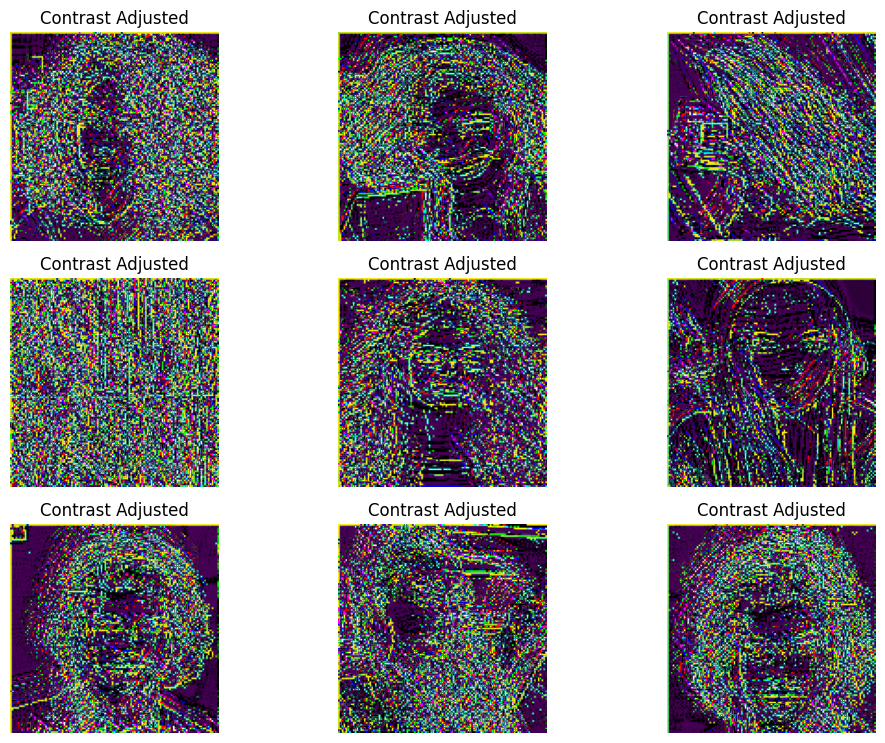

In [5]:
import matplotlib.pyplot as plt

# Function to display original and contrast-adjusted images
def display_contrast_effect(original_images, contrast_adjusted_images, num_images=9):
    num_rows = 4
    num_cols = 3
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # Display original images
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(original_images[i].numpy().astype("uint8"))
        plt.title('Original')
        plt.axis("off")
        
        # Display contrast-adjusted images
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(contrast_adjusted_images[i].numpy().squeeze(), cmap='gray')
        plt.title('Contrast Adjusted')
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Select a batch of images from the validation dataset
sample_images, _ = next(iter(val_ds))

# Perform inference using the trained model
contrast_adjusted_images = model.layers[0](sample_images, training=True)

# Display the original and contrast-adjusted images
display_contrast_effect(sample_images, contrast_adjusted_images)


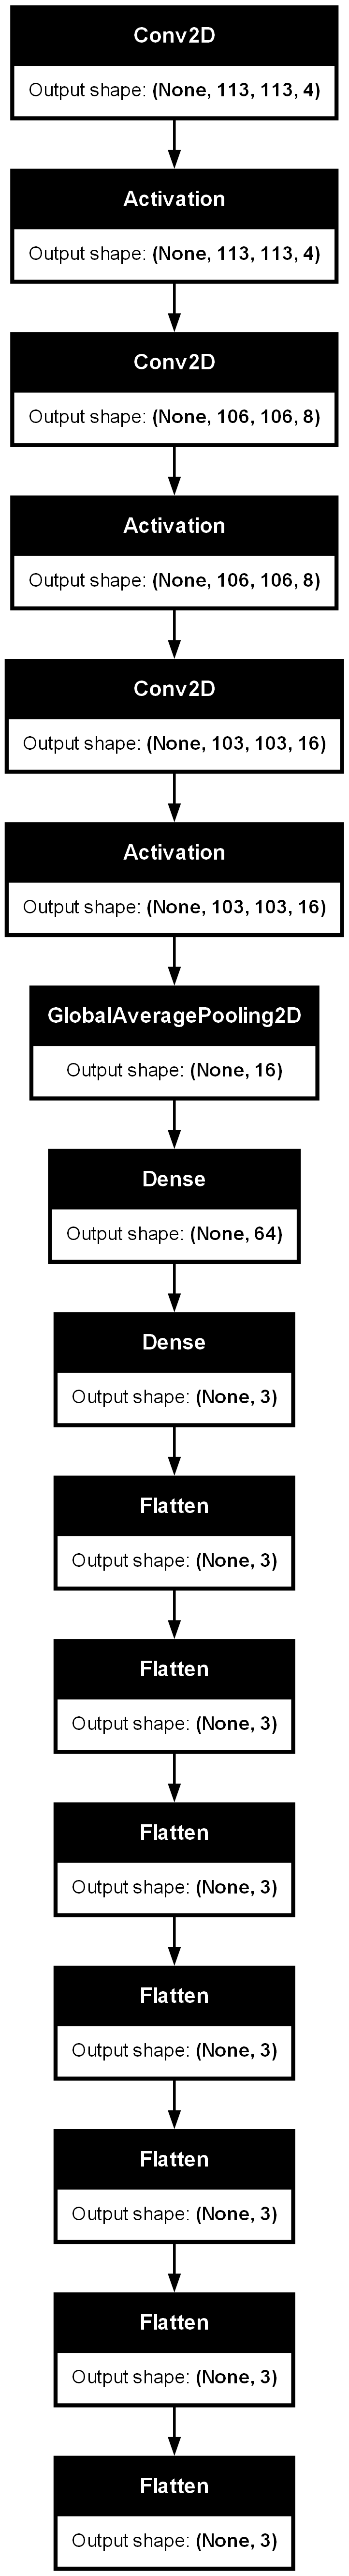

In [6]:
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 113, 113, 4)         │           1,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 113, 113, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 8)         │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 106, 106, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 103, 103, 16)        │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 103, 103, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,295 (75.38 KB)

 Trainable params: 6,431 (25.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,864 (50.25 KB)

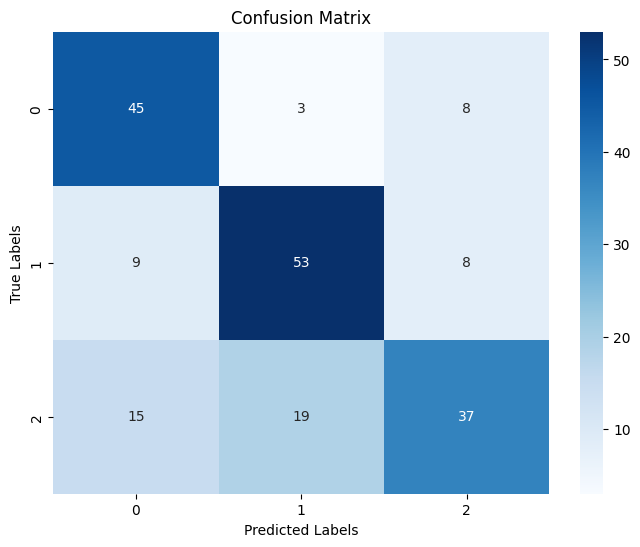

In [8]:
# Calculate confusion matrix
import seaborn as sns

conf_matrix = tf.math.confusion_matrix(labels=true_labels_list, predictions=predicted_labels_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

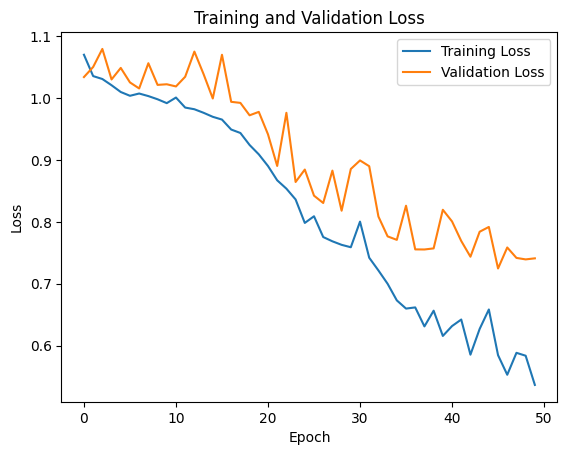

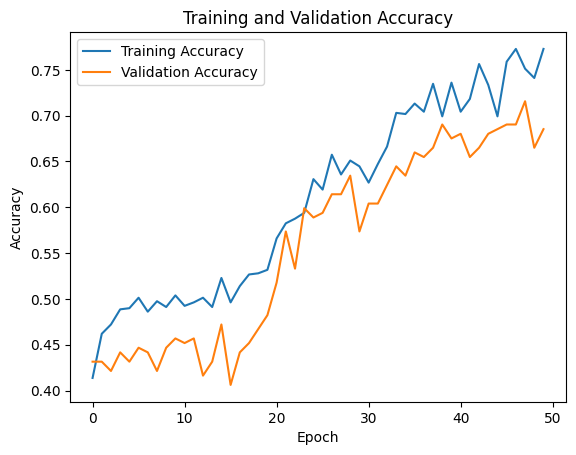

In [9]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
<stack traces unavailable>
Depth of output must be a multiple of the number of groups: 4 vs 3

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 737, in start
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 618, in run_forever
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1951, in _run_once
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 84, in _run
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
File "C:\Users\Sara Limeta\AppData\Local\Temp\ipykernel_41168\809347879.py", line 10, in <module>
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 519, in predict
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 217, in one_step_on_data_distributed
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 206, in one_step_on_data
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 98, in predict_step
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 825, in __call__
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\sequential.py", line 202, in call
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 195, in call
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\function.py", line 151, in _run_through_graph
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 579, in call
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 825, in __call__
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 224, in call
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 214, in convolution_op
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 909, in conv
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 279, in conv
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 269, in _conv_xla
File "C:\Users\Sara Limeta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 256, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference__conv_xla_26790[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[sequential_1/conv2d_1/StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_26881]

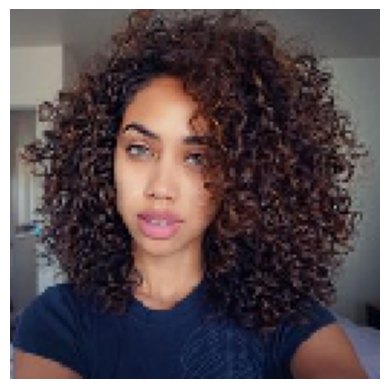

In [10]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)

plt.axis("off")
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)
